 # PtyRAD - PTYchographic Reconstruction with Automatic Differentiation

 Chia-Hao Lee

cl2696@cornell.edu

Created 2024.03.08

# 01. Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import numpy as np
import torch
from tifffile import imwrite

GPUID = 0
DEVICE = torch.device("cuda:" + str(GPUID))
print("Execution device: ", DEVICE)
print("PyTorch version: ", torch.__version__)
print("CUDA available: ", torch.cuda.is_available())
print("CUDA version: ", torch.version.cuda)
print("CUDA device:", torch.cuda.get_device_name(GPUID))

Execution device:  cuda:0
PyTorch version:  2.1.0
CUDA available:  True
CUDA version:  12.1
CUDA device: Quadro P5000


In [2]:
from ptyrad.initialization import Initializer
from ptyrad.models import PtychoAD
from ptyrad.optimization import CombinedLoss, ptycho_recon, loss_logger
from ptyrad.visualization import plot_forward_pass
from ptyrad.utils import test_loss_fn, make_batches

Importing from ptyrad


# 02. Initialize optimization

In [3]:
# CNS
ptycho_output_mat_path = "data/CNS_from_Hari/Niter10000.mat"
exp_CBED_path =          "data/CNS_from_Hari/240327_fov_23p044A_x_24p402A_thickness_9p978A_step0p28_conv30_dfm100_det70_TDS_2configs_xdirection_Co_0p25_Nb_0_S_0.mat" 

exp_params = {
    "kv"                : 300,  # kV
    "conv_angle"        : 30, # mrad, semi-convergence angle
    "Npix"              : 164, # Detector pixel number, EMPAD is 128. Only supports square detector for simplicity
    "rbf"               : None, # Pixels of radius of BF disk, used to calculate dk
    "dx_spec"           : 0.1406,# Ang
    "defocus"           : -100, # Ang, positive defocus here refers to actual underfocus or weaker lens strength following Kirkland/abtem/ptychoshelves convention
    "c3"                : 0, # Ang, spherical aberration coefficients
    "z_distance"        : 10, # Ang
    "Nlayer"            : 21,
    "N_scans"           : 4096,
    "omode_max"         : 1,
    "pmode_max"         : 1,
    "pmode_init_pows"   : [0.02],
    "probe_permute"     : None,
    "cbeds_permute"     : (0,1,3,2),
    "cbeds_reshape"     : (7134,164,164),
    "probe_simu_params" : None
    }

# Source and params, note that these should be changed in accordance with each other
source_params = {
    'measurements_source': 'mat',
    'measurements_params': [exp_CBED_path, 'cbed'],
    'obj_source'         : 'simu',
    'obj_params'         : (1,1,391,403),
    'probe_source'       : 'simu',
    'probe_params'       : None, 
    'pos_source'         : 'PtyShv',
    'pos_params'         : ptycho_output_mat_path,
    'omode_occu_source'  : 'uniform',
    'omode_occu_params'  : None
}


In [ ]:
# # PSO 256

# ptycho_output_mat_path = 'data/PSO/MLs_L1_p8_g32_pc50_noModel_vp1_Ns21_dz10_reg1/Niter200.mat'
# exp_CBED_path          = 'data/PSO/MLs_L1_p8_g32_pc50_noModel_vp1_Ns21_dz10_reg1/PSO_data_roi0_Ndp256_dp.hdf5'

# exp_params = {
#     "kv"                : 300,  # kV
#     "conv_angle"        : 21.4, # mrad, semi-convergence angle
#     "Npix"              : 256, # Detector pixel number, EMPAD is 128. Only supports square detector for simplicity
#     "rbf"               : None, # Pixels of radius of BF disk, used to calculate dk
#     "dx_spec"           : 0.0934,# Ang
#     "defocus"           : -200, # Ang, positive defocus here refers to actual underfocus or weaker lens strength following Kirkland/abtem/ptychoshelves convention
#     "c3"                : 0, # Ang, spherical aberration coefficients
#     "z_distance"        : 10, # Ang
#     "Nlayer"            : 21,
#     "N_scans"           : 4096,
#     "omode_max"         : 1,
#     "pmode_max"         : 8,
#     "pmode_init_pows"   : [0.02],
#     "probe_permute"     : None,
#     "cbeds_permute"     : (0,2,1),
#     "cbeds_reshape"     : None,
#     "probe_simu_params" : None
#     }

# # Source and params, note that these should be changed in accordance with each other
# source_params = {
#     'measurements_source': 'hdf5',
#     'measurements_params': [exp_CBED_path, 'dp'],
#     'obj_source'         : 'PtyShv',
#     'obj_params'         : ptycho_output_mat_path,
#     'probe_source'       : 'simu',
#     'probe_params'       : ptycho_output_mat_path,  # probe_simu_params
#     'pos_source'         : 'PtyShv',
#     'pos_params'         : ptycho_output_mat_path,
#     'omode_occu_source'  : 'uniform',
#     'omode_occu_params'  : None
# }


In [4]:
init = Initializer(exp_params, source_params).init_all()


### Initializing exp_params ###
kv: 300
conv_angle: 30
Npix: 164
rbf: None
dx_spec: 0.1406
defocus: -100
c3: 0
z_distance: 10
Nlayer: 21
N_scans: 4096
omode_max: 1
pmode_max: 1
pmode_init_pows: [0.02]
probe_permute: None
cbeds_permute: (0, 1, 3, 2)
cbeds_reshape: (7134, 164, 164)
probe_simu_params: None

### Initializing measurements from 'mat' ###
Can't load .mat v7.3 with scipy. Switching to h5py.
Success! .mat File path = data/CNS_from_Hari/240327_fov_23p044A_x_24p402A_thickness_9p978A_step0p28_conv30_dfm100_det70_TDS_2configs_xdirection_Co_0p25_Nb_0_S_0.mat
Permuting measurements
Reshaping measurements
measurements                      (N, Ky, Kx) = float32, (7134, 164, 164)

### Initializing obj from 'simu' ###
object                    (omode, Nz, Ny, Nx) = complex64, (1, 1, 391, 403)

### Initializing probe from 'simu' ###
exp_params[`probe_simu_params`] is incorrecly set to `None`, use exp_params and default values instead for simulation
Start simulating STEM probe
Using 'dx' 

In [5]:
model_params = {
    'init_variables': init.init_variables,
    'lr_params':{
        'obja': 0,
        'objp': 1e-3,
        'probe': 1e-3, 
        'probe_pos_shifts': 0}
}

model = PtychoAD(model_params, device=DEVICE)

# Use model.set_optimizer(new_lr_params) to update the variable flag and optimizer_params
optimizer = torch.optim.Adam(model.optimizer_params)

PtychoAD optimizable variables:
obja            : torch.Size([1, 1, 391, 403])    , torch.float32   , device:cuda:0, grad:False, lr:0e+00
objp            : torch.Size([1, 1, 391, 403])    , torch.float32   , device:cuda:0, grad:True , lr:1e-03
probe           : torch.Size([1, 164, 164])       , torch.complex64 , device:cuda:0, grad:True , lr:1e-03
probe_pos_shifts: torch.Size([7134, 2])           , torch.float32   , device:cuda:0, grad:False, lr:0e+00

Make sure to pass the optimizer_params to optimizer object using "optimizer = torch.optim.Adam(model.optimizer_params)"


In [ ]:
# # Use this to edit learning rate if needed some refinement

# model.set_optimizer(lr_params={'obja': 0,
#                                'objp': 1e-3,
#                                'probe': 1e-3, 
#                                'probe_pos_shifts': 0})
# optimizer=torch.optim.Adam(model.optimizer_params)

## Check the forward pass

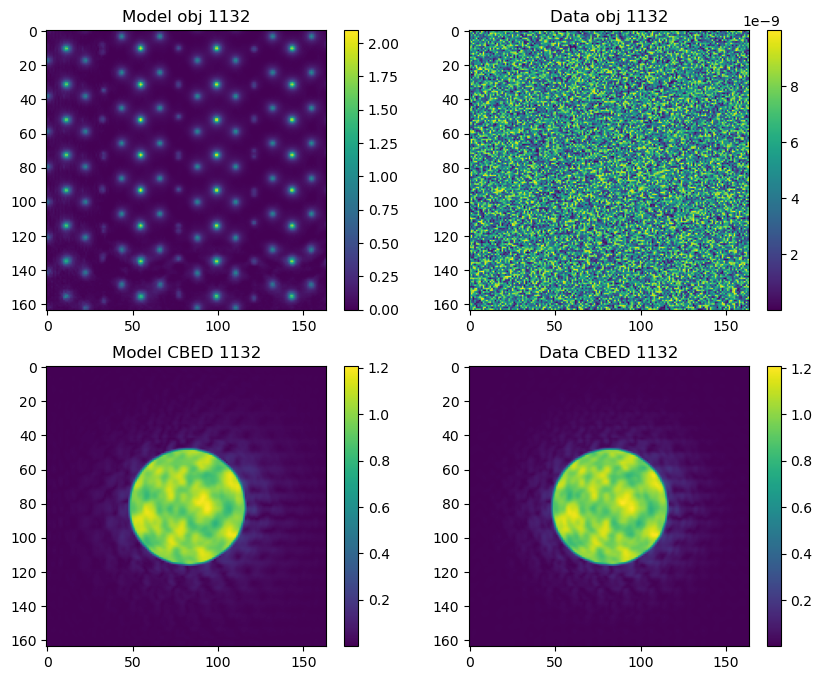

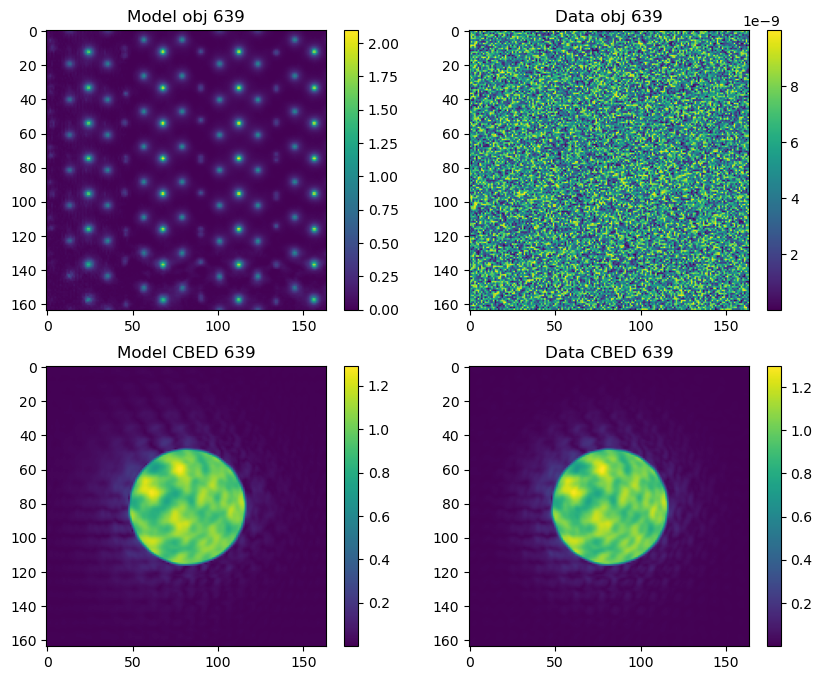

In [9]:
indices = np.random.randint(0,exp_params['N_scans'],2)
dp_power = 0.5

plot_forward_pass(model, indices, dp_power, init.init_variables['obj'])

## Finetune the loss params

In [7]:
loss_params = {
    'loss_single': {'state':  True,  'weight': 1.0, 'dp_pow': 0.5},
    'loss_pacbed': {'state': False,  'weight': 1.0, 'dp_pow': 0.2},
    'loss_tv'    : {'state': False,  'weight': 1e-4},
    'loss_l1'    : {'state': False,   'weight': 1e-2},
    'loss_l2'    : {'state': False,  'weight': 1.0},
    'loss_postiv': {'state':  True,  'weight': 1.0}
}

indices = np.random.randint(0,exp_params['N_scans'],32)
loss_fn = CombinedLoss(loss_params, device=DEVICE)
test_loss_fn(model, indices, loss_fn)

loss_single: 0.59946668
loss_pacbed: 0.00000000
loss_tv    : 0.00000000
loss_l1    : 0.00000000
loss_l2    : 0.00000000
loss_postiv: 0.00000000


# 03. Main optimization loop

In [8]:
NITER = 20
BATCH_SIZE = 32
N_scans = exp_params['N_scans']
num_batch = N_scans / BATCH_SIZE # The actual batch size would only be "close" if it's not divisible by len(measurments)
loss_iters = []

# output_path = 'output/PSO/PSO_1obj_21slice_1e-3_dppow0.5_b64/'
# os.makedirs(output_path, exist_ok=True)

for iter in range(NITER+1):
    batches = make_batches(N_scans, num_batch)
    batch_losses, iter_t = ptycho_recon(batches, model, optimizer, loss_fn)
    loss_iters.append(loss_logger(batch_losses, iter, iter_t))
    
    # ## Saving
    # if iter % 10 == 0:
    #     torch.save(model.state_dict(), os.path.join(output_path, f"model_iter{str(iter).zfill(4)}.pt"))
    #     imwrite(os.path.join(output_path, f"objp_iter{str(iter).zfill(4)}_stack.tif"), model.opt_objp[0].detach().cpu().numpy().astype('float32'))
    #     imwrite(os.path.join(output_path, f"objp_iter{str(iter).zfill(4)}_zsum.tif"), model.opt_objp[0].sum(0).detach().cpu().numpy().astype('float32'))

Done batch 0 in 0.307 sec
Done batch 25 in 0.004 sec
Done batch 50 in 0.016 sec
Done batch 76 in 0.016 sec
Done batch 101 in 0.009 sec
Done batch 127 in 0.016 sec
Iter: 0, Total Loss: 0.3555, loss_single: 0.3528, loss_pacbed: 0.0000, loss_tv: 0.0000, loss_l1: 0.0000, loss_l2: 0.0000, loss_postiv: 0.0027, in 0.0 min 1.674845 sec
Done batch 0 in 0.011 sec
Done batch 25 in 0.010 sec
Done batch 50 in 0.011 sec
Done batch 76 in 0.008 sec
Done batch 101 in 0.000 sec
Done batch 127 in 0.016 sec
Iter: 1, Total Loss: 0.2189, loss_single: 0.2121, loss_pacbed: 0.0000, loss_tv: 0.0000, loss_l1: 0.0000, loss_l2: 0.0000, loss_postiv: 0.0068, in 0.0 min 1.373722 sec
Done batch 0 in 0.017 sec
Done batch 25 in 0.015 sec
Done batch 50 in 0.010 sec
Done batch 76 in 0.004 sec
Done batch 101 in 0.016 sec
Done batch 127 in 0.016 sec
Iter: 2, Total Loss: 0.1987, loss_single: 0.1926, loss_pacbed: 0.0000, loss_tv: 0.0000, loss_l1: 0.0000, loss_l2: 0.0000, loss_postiv: 0.0062, in 0.0 min 1.402410 sec
Done batch

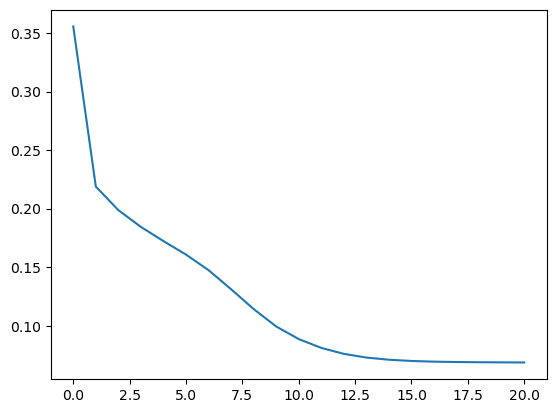

In [10]:
plt.figure()
plt.plot(loss_iters)
plt.show()